In [1]:
import io
import base64
import time
import pickle
import pandas as pd
import numpy as np
from helper_fcts import preprocess, get_poi_mas, rps
from momentum import get_momentum
from exp_goals_poisson import get_poisson
from massey_ratings_adv import get_massey
from keras import backend as K
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
from scipy.interpolate import spline
from IPython.display import YouTubeVideo, SVG, HTML
from magic_predict import get_prediction
from operator import itemgetter
from scipy.stats import poisson
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D

def save_obj(obj, name):
    with open('C:/Users/Konny/DataScience/SpicedAcademy/fussball_vorhersagen/data/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open('C:/Users/Konny/DataScience/SpicedAcademy/fussball_vorhersagen/data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def get_statistics(df, i):
    df["season"] = i
    df = preprocess(df)
    df = get_poisson(df, "ALL")
    df = get_massey(df, 20)
    df = get_poi_mas(df)
    return df

liste = [get_statistics(load_obj("Eng"+str(i)), i) for i in range(11,19)]
df = pd.concat(liste)

C:\Users\Konny\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Konny\Anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:493: RuntimeWarning: invalid value encountered in greater_equal
  return mu >= 0


![](bookie_big.jpg)

![](animal_predictions.png)

## Data Science Work-Flow
1. problem definition
2. data exploration
3. feature engineering
4. modelling
5. evaluation

## 1. Definition of the problem

#### 1.1 Accuracy
- not a good measure
- for example: 50% accuracy when betting on favorites is worse than 50% accuracy when betting on underdogs

#### 1.2 Classification
- Difficult to measure/compare

In [2]:
df["Res"] = np.where(df["FTHG"] > df["FTAG"], "green", np.where(df["FTHG"] == df["FTAG"], "yellow", "red"))
df_vis = df[df["season"] == 18].loc[:,["Res", "H_prob_odds", "D_prob_odds", "A_prob_odds"]]

In [3]:
%matplotlib notebook

<IPython.core.display.Javascript object>


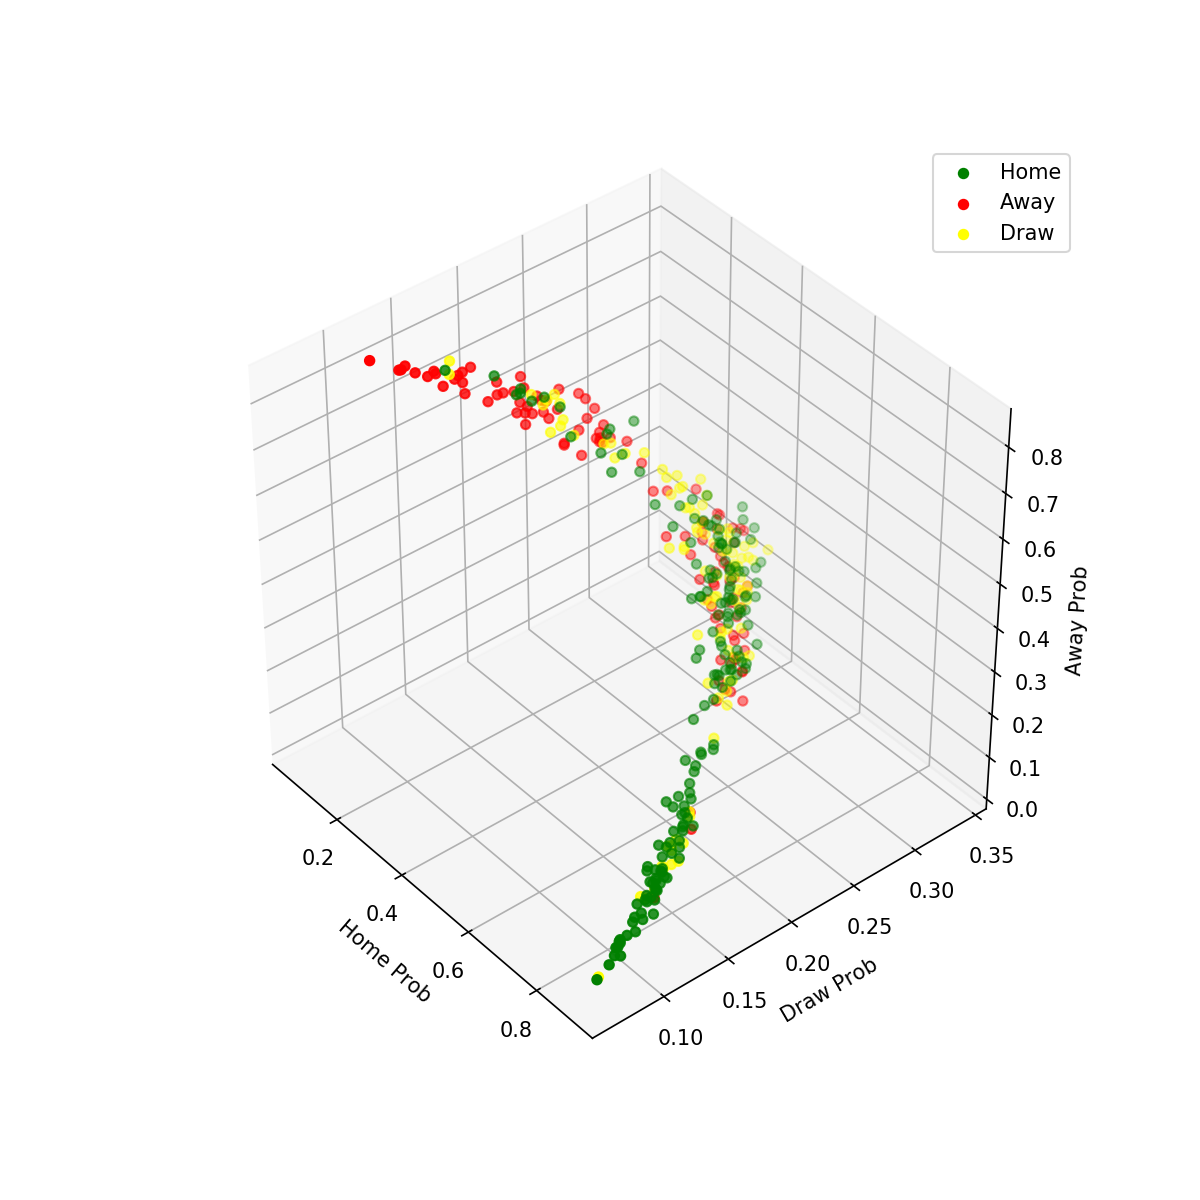

In [4]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

for res, group in df_vis.groupby("Res"):
    ax.scatter(group["H_prob_odds"], group["D_prob_odds"], group["A_prob_odds"], c=res)

ax.legend(["Home", "Away", "Draw"])

ax.set_xlabel('Home Prob')
ax.set_ylabel('Draw Prob')
ax.set_zlabel('Away Prob')

plt.show()

In [5]:
%matplotlib inline

### 1.3 Rank Probability Score (RPS)
- score to rank predictions
- the lower the better
- good measure

In [58]:
print("---------------------------------------")
print(f"\nBookmaker RPS: {np.round(df[(df['season'] == 18) & (df['round'] > 10)]['rps_Book'].mean(),4)}\n")
print("---------------------------------------")

---------------------------------------

Bookmaker RPS: 0.1826

---------------------------------------


## 2. Data Exploration
- Premier League
- Seasons 10/11 to 17/18

### 2.1 Sources:
- football-data.co.uk
- sportdeer.com (API)

In [8]:
df[["Date", "season", "round", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR", "HS", "HST", "AS", "AST", "BbAvH", "BbAvD", "BbAvA"]].head(20)

,Date,season,round,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,HST,AS,AST,BbAvH,BbAvD,BbAvA
0,14/08/10,11,1,Tottenham,Manchester City,0,0,D,22,18,11,7,2.39,3.28,2.95
1,14/08/10,11,1,Wolverhampton Wanderers,Stoke,2,1,H,13,7,10,6,2.33,3.22,3.11
2,14/08/10,11,1,Sunderland,Birmingham,2,2,D,6,2,13,7,2.18,3.25,3.39
3,14/08/10,11,1,Blackburn,Everton,1,0,H,7,2,17,12,2.92,3.25,2.44
4,14/08/10,11,1,Bolton,Fulham,0,0,D,13,9,12,7,2.20,3.26,3.32
5,14/08/10,11,1,Aston Villa,West Ham,3,0,H,23,11,12,2,1.96,3.30,4.03
6,14/08/10,11,1,Wigan,Blackpool,0,4,A,11,6,9,7,1.82,3.45,4.50
7,14/08/10,11,1,Chelsea,West Bromwich Albion,6,0,H,18,13,10,4,1.16,6.90,17.47
8,15/08/10,11,1,Liverpool,Arsenal,1,1,D,7,4,14,7,2.47,3.24,2.89
9,16/08/10,11,1,Manchester United,Newcastle United,3,0,H,18,10,7,3,1.23,5.63,13.11


### 2.2 Home/Draw/Away Distribution

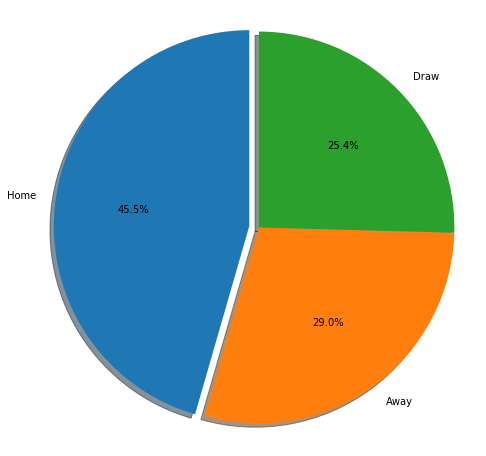

In [9]:
home_wins = np.round(df[df["FTR"]=="H"].shape[0] * 100 / df.shape[0], 2)
draw_wins = np.round(df[df["FTR"]=="D"].shape[0] * 100 / df.shape[0], 2) 
away_wins = np.round(df[df["FTR"]=="A"].shape[0] * 100 / df.shape[0], 2) 

labels = 'Home', 'Away', 'Draw'
sizes = [home_wins, away_wins, draw_wins]
explode = (0.05, 0, 0)

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

## 3. Feature Engineering

In [11]:
df[["Date", "season", "round", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR", "HS", "HST", "AS", "AST", "BbAvH", "BbAvD", "BbAvA"]].head(5)

,Date,season,round,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,HST,AS,AST,BbAvH,BbAvD,BbAvA
0,14/08/10,11,1,Tottenham,Manchester City,0,0,D,22,18,11,7,2.39,3.28,2.95
1,14/08/10,11,1,Wolverhampton Wanderers,Stoke,2,1,H,13,7,10,6,2.33,3.22,3.11
2,14/08/10,11,1,Sunderland,Birmingham,2,2,D,6,2,13,7,2.18,3.25,3.39
3,14/08/10,11,1,Blackburn,Everton,1,0,H,7,2,17,12,2.92,3.25,2.44
4,14/08/10,11,1,Bolton,Fulham,0,0,D,13,9,12,7,2.20,3.26,3.32


### 3.1 Averages
- match statistics cannot be used, because we dont know them before the match
- we use averages over the past games instead

In [13]:
df[["HomeTeam", "AwayTeam", "H_avgG", "A_avgG", "H_avgG_c", "A_avgG_c", "H_avgST", "A_avgST", "H_avgST_c", "A_avgST_c", "LgHG", "LgAG"]].tail(5)

,HomeTeam,AwayTeam,H_avgG,A_avgG,H_avgG_c,A_avgG_c,H_avgST,A_avgST,H_avgST_c,A_avgST_c,LgHG,LgAG
375,Manchester United,Watford,2.055556,0.944444,0.500000,1.777778,5.111111,3.277778,3.444444,4.333333,1.541333,1.152000
376,Swansea,Stoke,0.888889,0.722222,1.222222,2.055556,3.222222,3.388889,4.500000,6.222222,1.539894,1.148936
377,Huddersfield,Arsenal,0.888889,1.055556,1.333333,1.722222,2.888889,4.611111,4.055556,4.222222,1.538462,1.151194
378,Southampton,Manchester City,1.111111,2.444444,1.388889,0.722222,4.111111,6.000000,4.000000,2.444444,1.534392,1.150794
379,Crystal Palace,West Bromwich Albion,1.500000,0.555556,1.500000,1.388889,4.777778,2.666667,4.444444,4.666667,1.530343,1.150396


### 3.2 Ratings

In [14]:
df1 = df[df["season"] == 18][["round", "HomeTeam", "AwayTeam", "H_Off_Rat", "H_Def_Rat", "A_Off_Rat", "A_Def_Rat"]]

home_off = df1.pivot(index="round", columns="HomeTeam", values="H_Off_Rat")
home_def = df1.pivot(index="round", columns="HomeTeam", values="H_Def_Rat")
away_off = df1.pivot(index="round", columns="AwayTeam", values="A_Off_Rat")
away_def = df1.pivot(index="round", columns="AwayTeam", values="A_Def_Rat")

home_off.fillna(method="pad", inplace=True)
home_off = home_off.iloc[10:]

home_def.fillna(method="pad", inplace=True)
home_def = home_def.iloc[10:]

away_off.fillna(method="pad", inplace=True)
away_off = away_off.iloc[10:]

away_def.fillna(method="pad", inplace=True)
away_def = away_def.iloc[10:]

home_off_df = pd.DataFrame(sorted(home_off.mean().items(), reverse=True, key=itemgetter(1)), columns=["Team", "Rating"]).set_index("Team")
home_def_df = pd.DataFrame(sorted(home_def.mean().items(), reverse=True, key=itemgetter(1)), columns=["Team", "Rating"]).set_index("Team")
away_off_df = pd.DataFrame(sorted(away_off.mean().items(), reverse=True, key=itemgetter(1)), columns=["Team", "Rating"]).set_index("Team")
away_def_df = pd.DataFrame(sorted(away_def.mean().items(), reverse=True, key=itemgetter(1)), columns=["Team", "Rating"]).set_index("Team")

all_rat = pd.concat([home_off_df, home_def_df, away_off_df, away_def_df], axis=1)
all_rat.columns = ["Home_Off", "Home_Def", "Away_Off", "Away_Def"]
all_rat["Offense"] = (all_rat["Home_Off"] + all_rat["Away_Off"]) / 2
all_rat["Defense"] = (all_rat["Home_Def"] + all_rat["Away_Def"]) / 2

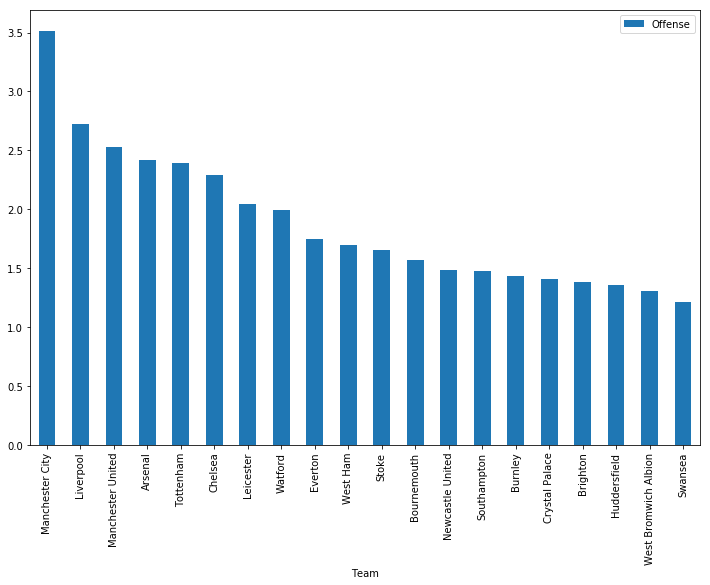

In [57]:
pd.DataFrame(sorted(all_rat["Offense"].items(), reverse=True, key=itemgetter(1)), columns=["Team", "Offense"]).set_index("Team").plot(figsize=(12,8),kind="bar")

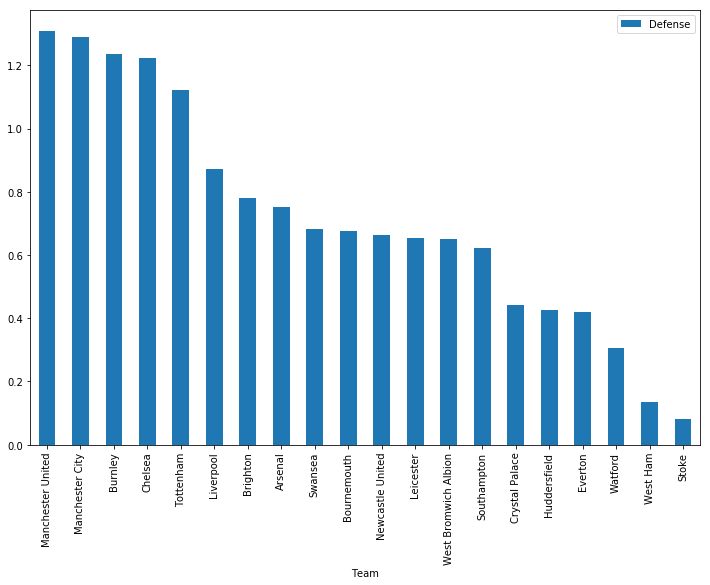

In [19]:
pd.DataFrame(sorted(all_rat["Defense"].items(), reverse=True, key=itemgetter(1)), columns=["Team", "Defense"]).set_index("Team").plot(figsize=(12,8),kind="bar")

### 3.3 Momentum

- Goal difference of the last match
- momentum over the last 4 matches

In [20]:
df[["HomeTeam", "AwayTeam", "H_Form_Tot4", "A_Form_Tot4", "GoalDiff_last_home", "GoalDiff_last_away"]].tail(10)

,HomeTeam,AwayTeam,H_Form_Tot4,A_Form_Tot4,GoalDiff_last_home,GoalDiff_last_away
370,Burnley,Bournemouth,0.476637,0.799312,-5.0,1.0
371,Tottenham,Leicester,0.741884,0.775903,1.0,2.0
372,West Ham,Everton,1.282501,1.431393,0.0,0.0
373,Liverpool,Brighton,0.613125,1.691363,-1.0,-2.0
374,Newcastle United,Chelsea,0.000000,1.233296,-1.0,0.0
375,Manchester United,Watford,0.893170,0.908669,0.0,1.0
376,Swansea,Stoke,0.000000,0.678686,-1.0,-1.0
377,Huddersfield,Arsenal,1.486229,0.904059,0.0,-2.0
378,Southampton,Manchester City,1.315269,0.967432,1.0,2.0
379,Crystal Palace,West Bromwich Albion,1.592183,4.014340,1.0,1.0


## 4. Models
- an old statistical model
- a machine learning model
- a deep learning model

### 4.1 Poisson

- one of the first models for football (80s)
- team specific strengths for attack and defense
- expected goals
- uses the fact that goals follow roughly a poisson distribution

C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


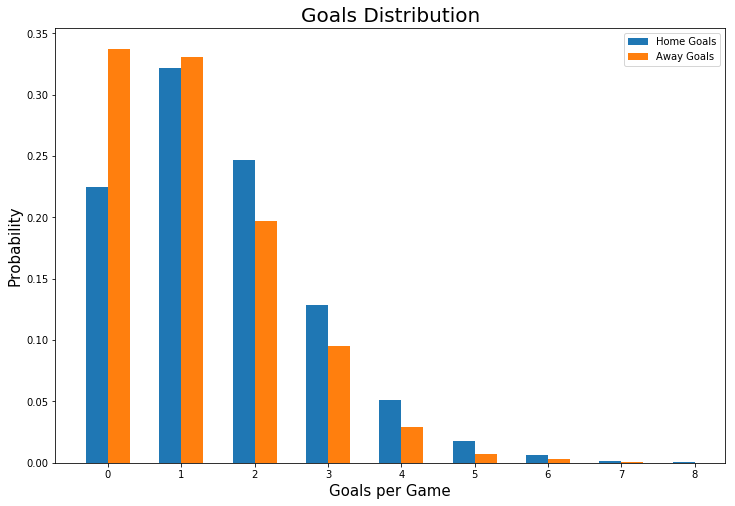

In [60]:
home_pois = [poisson.pmf(i, home_mean) * 3040 for i in range(9)]
away_pois = [poisson.pmf(i, away_mean) * 3040 for i in range(9)]

xnew = np.linspace(0, 8, 300)

home_pois_sm = spline(range(9),home_pois,xnew)
away_pois_sm = spline(range(9),away_pois,xnew)

plt.figure(figsize = (12,8))          

plt.title("Goals Distribution", fontsize=20)

plt.bar(home_goals.index-0.15, home_goals.values / df.shape[0], 0.3, label='Home Goals')
plt.bar(away_goals.index+0.15, away_goals.values / df.shape[0], 0.3, label='Away Goals')

#plt.plot(xnew, home_pois_sm/ df.shape[0], color='blue',lw=3, ls="dashed", label='Home Poisson, mean: 1.55')
#plt.plot(xnew, away_pois_sm/ df.shape[0], color='red', lw=3, ls="dashed", label='Away Poisson, mean: 1.18')

plt.ylabel('Probability', fontsize= 15)
plt.xlabel('Goals per Game', fontsize=15)
plt.xticks(np.arange(0, 9, step=1))
plt.legend()

plt.show()

In [61]:
home_goals = df.groupby("FTHG")["FTHG"].count()
away_goals = df.groupby("FTAG")["FTAG"].count()
home_mean = df["FTHG"].mean()
away_mean = df["FTAG"].mean()
print(f"\nAverage Home Goals per game: {np.round(home_mean, 2)}\n")
print(f"\nAverage Away Goals per game: {np.round(away_mean, 2)}\n")


Average Home Goals per game: 1.55


Average Away Goals per game: 1.18



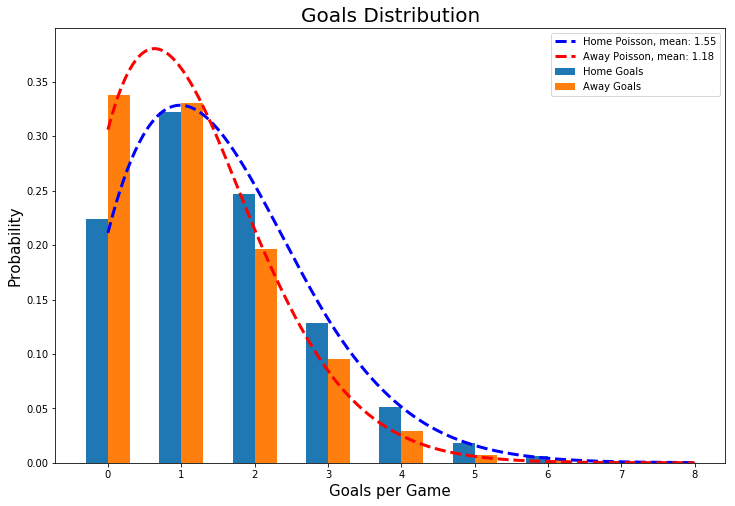

In [62]:
plt.figure(figsize = (12,8))          

plt.title("Goals Distribution", fontsize=20)

plt.bar(home_goals.index-0.15, home_goals.values / df.shape[0], 0.3, label='Home Goals')
plt.bar(away_goals.index+0.15, away_goals.values / df.shape[0], 0.3, label='Away Goals')

plt.plot(xnew, home_pois_sm/ df.shape[0], color='blue',lw=3, ls="dashed", label='Home Poisson, mean: 1.55')
plt.plot(xnew, away_pois_sm/ df.shape[0], color='red', lw=3, ls="dashed", label='Away Poisson, mean: 1.18')

plt.ylabel('Probability', fontsize= 15)
plt.xlabel('Goals per Game', fontsize=15)
plt.xticks(np.arange(0, 9, step=1))
plt.legend()

plt.show()

In [63]:
print("--------------------------------------------")
print(f"Bookmaker RPS: {np.round(df[(df['round'] > 10) & (df['season'] == 18)]['rps_Book'].mean(), 4)}")
print("--------------------------------------------")
print(f"Poisson Model RPS: {np.round(df[(df['round'] > 10) & (df['season'] == 18)]['rps_PoiG'].mean(), 4)}")
print("--------------------------------------------")

--------------------------------------------
Bookmaker RPS: 0.1826
--------------------------------------------
Poisson Model RPS: 0.2107
--------------------------------------------


### 4.2 Random Forest

In [64]:
columns_mit_fe  = ['FTR', 'season', 'H_avg_GoalDiff', 'A_avg_GoalDiff', 'H_avgG', 'A_avgG', 'H_avgG_c', 'A_avgG_c', 'GoalDiff_last_away', 'GoalDiff_last_home', 'H_xG_PoiMas', 'A_xG_PoiMas', 'H_Form_Tot4', 'A_Form_Tot4','H_Def_Rat', 'H_Off_Rat', 'A_Def_Rat', 'A_Off_Rat', "H_prob_odds", "D_prob_odds", "A_prob_odds"]
data2 = df[df["round"] > 10].reset_index(drop=True)
data = data2.loc[:,columns_mit_fe]
data.dropna(inplace=True)
X_train = data[data["season"]<18].iloc[:,1:]
X_test = data[data["season"]==18].iloc[:,1:]
y_train = data[data["season"]<18].loc[:,"FTR"]
y_test = data[data["season"]==18].loc[:,"FTR"]

![](Decision_Trees.svg)

![](Random_Forest.svg)

In [66]:
clf = RandomForestClassifier(n_estimators=250,max_depth=3, random_state=30)

In [67]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=30, verbose=0, warm_start=False)

In [68]:
prediction = clf.predict_proba(X_test)

In [69]:
test_df = data2[data2["season"] == 18]
test_df.reset_index(drop=True, inplace=True)
test_df2 = pd.concat([test_df, pd.DataFrame(prediction, columns = ["Clf_A", "Clf_D", "Clf_H"])], axis=1)
test_df2["rps_Clf"] = rps(test_df2["Clf_H"], test_df2["Clf_D"], test_df2["Clf_A"], test_df2["Home"], test_df2["Draw"], test_df2["Away"])

In [70]:
print("--------------------------------------------")
print(f"Bookmaker RPS: {np.round(test_df2['rps_Book'].mean(), 4)}")
print("--------------------------------------------")
print(f"Random Forest RPS: {np.round(test_df2['rps_Clf'].mean(), 4)}")
print("--------------------------------------------")

--------------------------------------------
Bookmaker RPS: 0.1826
--------------------------------------------
Random Forest RPS: 0.1852
--------------------------------------------


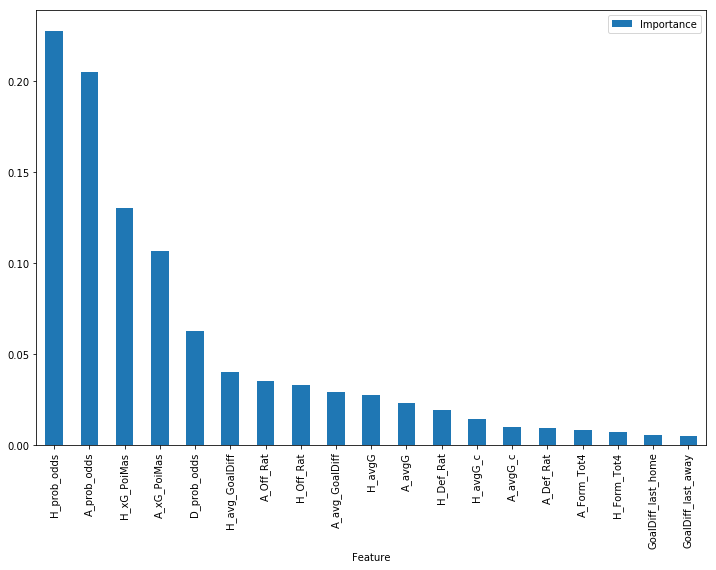

In [71]:
%matplotlib inline
importance = sorted(zip(X_train.columns, clf.feature_importances_), key=itemgetter(1), reverse=True)
fe_imp = pd.DataFrame(importance, columns=["Feature", "Importance"]).set_index("Feature")
fe_imp.drop("season", inplace=True)
fe_imp.plot(figsize=(12, 8),kind='bar')

### 4.3 Artificial Neural Network

In [72]:
columns_mit_fe  = ['Home', 'Draw', 'Away', 'season', 'H_avg_GoalDiff', 'A_avg_GoalDiff', 'H_avgS', 'A_avgS', 'H_avgS_c', 'A_avgS_c', 'H_avgST', 'A_avgST', 'H_avgST_c', 'A_avgST_c', 'GoalDiff_last_away', 'GoalDiff_last_home', 'H_xG_PoiMas', 'A_xG_PoiMas', 'H_Form_Tot4', 'A_Form_Tot4', 'H_prob_odds', 'D_prob_odds', 'A_prob_odds']

In [73]:
def get_season(df, season):
    X_train = df[df["season"] != season].iloc[:,3:]
    X_test = df[df["season"] == season].iloc[:,3:]
    y_train = df[df["season"] != season].iloc[:,:3]
    y_test = df[df["season"] == season].iloc[:,:3]
    return X_train, X_test, y_train, y_test


def get_scale(X):
    for col in X.columns:
        X[col] = scale(X[col])
    return X

def loss_rps(y_true, y_pred):
    prob_h = y_pred[:, 0]
    prob_d = y_pred[:, 1]
    home = y_true[:, 0]
    draw = y_true[:, 1]

    step1 = prob_h - home
    step2 = prob_d - draw
    summe = step1 + step2
    return (step1 ** 2 + summe ** 2) / 2

K.clear_session()

model2 = Sequential()
model2.add(Dense(64, kernel_initializer="he_normal", input_shape=(20,)))
model2.add(Dense(32, kernel_initializer="he_normal"))
model2.add(Dense(16, kernel_initializer="he_normal"))
model2.add(Dense(3, kernel_initializer="he_normal"))

data2 = df[df["round"] > 10].reset_index(drop=True)
data = data2[columns_mit_fe]

X_train, X_test, y_train, y_test = get_season(data, 18)
X_train = get_scale(X_train)
X_test = get_scale(X_test)


C:\Users\Konny\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [74]:
K.clear_session()

model = Sequential()
model.add(Dense(64, kernel_initializer="he_normal", input_shape=(20,)))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(16, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(3, kernel_initializer="he_normal"))
model.add(Activation('softmax'))

model.compile(loss=loss_rps, optimizer='adam', metrics=['accuracy'])

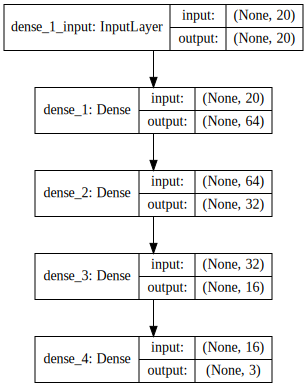

In [75]:
SVG(model_to_dot(model2,  show_shapes=True,
    show_layer_names=True, rankdir='HB').create(
       prog='dot', format='svg'))

In [76]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
1960/1960 [==============================] - 1s 726us/step - loss: 0.3159 - acc: 0.3459
Epoch 2/100
1960/1960 [==============================] - 0s 84us/step - loss: 0.2705 - acc: 0.4046: 0s - loss: 0.2710 - acc: 0.40
Epoch 3/100
1960/1960 [==============================] - 0s 74us/step - loss: 0.2676 - acc: 0.4168
Epoch 4/100
1960/1960 [==============================] - 0s 76us/step - loss: 0.2479 - acc: 0.4311
Epoch 5/100
1960/1960 [==============================] - 0s 62us/step - loss: 0.2395 - acc: 0.4434
Epoch 6/100
1960/1960 [==============================] - 0s 62us/step - loss: 0.2385 - acc: 0.4668
Epoch 7/100
1960/1960 [==============================] - 0s 61us/step - loss: 0.2308 - acc: 0.4607
Epoch 8/100
1960/1960 [==============================] - 0s 60us/step - loss: 0.2273 - acc: 0.4571
Epoch 9/100
1960/1960 [==============================] - 0s 61us/step - loss: 0.2191 - acc: 0.5010
Epoch 10/100
1960/1960 [==============================] - 0s 65us/step - loss

1960/1960 [==============================] - 0s 64us/step - loss: 0.1943 - acc: 0.5520
Epoch 83/100
1960/1960 [==============================] - 0s 53us/step - loss: 0.1960 - acc: 0.5469
Epoch 84/100
1960/1960 [==============================] - 0s 52us/step - loss: 0.1934 - acc: 0.5592
Epoch 85/100
1960/1960 [==============================] - 0s 50us/step - loss: 0.1942 - acc: 0.5520
Epoch 86/100
1960/1960 [==============================] - 0s 50us/step - loss: 0.1937 - acc: 0.5561
Epoch 87/100
1960/1960 [==============================] - 0s 53us/step - loss: 0.1949 - acc: 0.5582
Epoch 88/100
1960/1960 [==============================] - 0s 49us/step - loss: 0.1918 - acc: 0.5648
Epoch 89/100
1960/1960 [==============================] - 0s 52us/step - loss: 0.1954 - acc: 0.5403
Epoch 90/100
1960/1960 [==============================] - 0s 50us/step - loss: 0.1947 - acc: 0.5480
Epoch 91/100
1960/1960 [==============================] - 0s 51us/step - loss: 0.1955 - acc: 0.5495
Epoch 92/100


In [77]:
#print("--------------------------------------------")
#print(f"Train Dataset:\n RPS: {np.round(model.evaluate(X_train, y_train, verbose=0)[0],4)}, Accuracy: {np.round(model.evaluate(X_train, y_train, verbose=0)[1],4)}")
print("--------------------------------------------")
print(f"Test Dataset:\n RPS: {np.round(model.evaluate(X_test, y_test, verbose=0)[0],4)}, Accuracy: {np.round(model.evaluate(X_test, y_test, verbose=0)[1],4)}")
print("--------------------------------------------")

--------------------------------------------
Test Dataset:
 RPS: 0.1872, Accuracy: 0.5393
--------------------------------------------


In [78]:
y_pred = model.predict(X_test)

In [79]:
test_df = data2[data2["season"] == 18]
test_df.reset_index(drop=True, inplace=True)
clf_pred = pd.DataFrame(prediction, columns = ["A_pred_Clf", "D_pred_Clf", "H_pred_Clf"])
ann_pred = pd.DataFrame(y_pred, columns = ["H_pred_Ann", "D_pred_Ann", "A_pred_Ann"])
test_df2 = pd.concat([test_df, clf_pred, ann_pred], axis=1)
test_df2["rps_Clf"] = rps(test_df2["H_pred_Clf"], test_df2["D_pred_Clf"], test_df2["A_pred_Clf"], test_df2["Home"], test_df2["Draw"], test_df2["Away"])
test_df2["rps_ANN"] = rps(test_df2["H_pred_Ann"], test_df2["D_pred_Ann"], test_df2["A_pred_Ann"], test_df2["Home"], test_df2["Draw"], test_df2["Away"])

In [80]:
print("--------------------------------------------")
print(f"Bookmaker RPS: {np.round(test_df2['rps_Book'].mean(), 4)}")
print("--------------------------------------------")
print(f"Random Forest RPS: {np.round(test_df2['rps_Clf'].mean(), 4)}")
print("--------------------------------------------")
print(f"Neural Network RPS: {np.round(test_df2['rps_ANN'].mean(), 4)}")
print("--------------------------------------------")
print(f"Poisson model RPS: {np.round(test_df2['rps_PoiG'].mean(), 4)}")
print("--------------------------------------------")

--------------------------------------------
Bookmaker RPS: 0.1826
--------------------------------------------
Random Forest RPS: 0.1852
--------------------------------------------
Neural Network RPS: 0.1872
--------------------------------------------
Poisson model RPS: 0.2107
--------------------------------------------


## 5. Betting Strategy

In [81]:
test_df2[["HomeTeam", "AwayTeam", "H_prob_odds", "H_pred_Clf", "H_pred_Ann"]].tail()

,HomeTeam,AwayTeam,H_prob_odds,H_pred_Clf,H_pred_Ann
275,Manchester United,Watford,0.635524,0.668405,0.700303
276,Swansea,Stoke,0.469754,0.482120,0.441220
277,Huddersfield,Arsenal,0.170754,0.211687,0.138882
278,Southampton,Manchester City,0.153666,0.191472,0.187056
279,Crystal Palace,West Bromwich Albion,0.544572,0.531888,0.538567


In [82]:
a = test_df2[(test_df2["H_pred_Ann"] / test_df2["H_prob_odds"] -1 > 0.1) & (test_df2["H_pred_Clf"] / test_df2["H_prob_odds"] -1 > 0.1)]["H_Ahc_PL"].describe()
print(f"\nBets on Home Teams:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(a['count'])}\nAvg. Yield: {np.round(a['mean'] * 100, 2)}%\n")


Bets on Home Teams:

Nr of Matches: 280
Nr of Bets: 45
Avg. Yield: 11.86%



In [83]:
b = test_df2[(test_df2["A_pred_Ann"] / test_df2["A_prob_odds"] -1 > 0.1) & (test_df2["A_pred_Clf"] / test_df2["A_prob_odds"] -1 > 0.1)]["A_Ahc_PL"].describe()
print(f"\nBets on Away Teams:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(b['count'])}\nAvg. Yield: {np.round(b['mean'] * 100, 2)}%\n")


Bets on Away Teams:

Nr of Matches: 280
Nr of Bets: 32
Avg. Yield: 3.64%



In [84]:
c = test_df2[(test_df2["D_pred_Ann"] / test_df2["D_prob_odds"] -1 > 0.1) & (test_df2["D_pred_Clf"] / test_df2["D_prob_odds"] -1 > 0.1)]["D_PL"].describe()
print(f"\nBets on Draws:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(c['count'])}\nAvg. Yield: {np.round(c['mean'] * 100, 2)}%\n")


Bets on Draws:

Nr of Matches: 280
Nr of Bets: 39
Avg. Yield: 13.23%



## 6. Still To Do:
- LineUps
- Market Value
- Twitter Sentiment Analysis of the matches